,January,February,March,April,May,June
transaction_items,,,,,,
Beef Chicharon,9665,10001,9816,9890,10028,9902
Gummy Vitamins,9681,9980,10145,9842,9948,9980
Gummy Worms,9559,9996,9986,10043,9801,9934
Kimchi and Seaweed,9676,9949,9967,9921,9773,10104
Nutrional Milk,9727,9691,9876,9786,9881,9767
Orange Beans,9774,10037,9611,9914,9964,10106
Yummy Vegetables,9959,10256,9896,9861,9735,9722


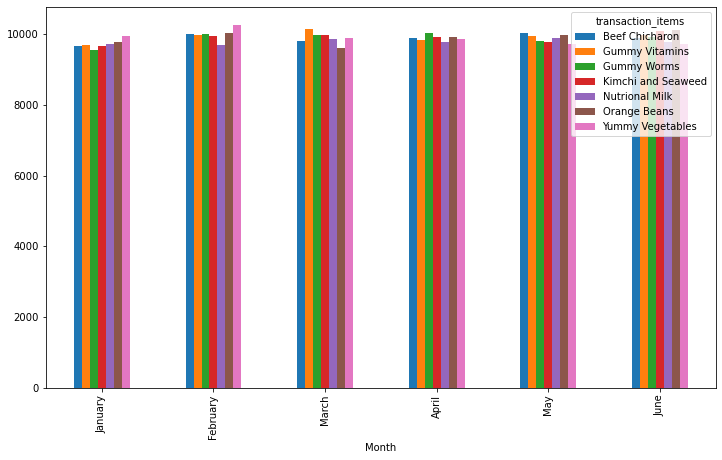

,January,February,March,April,May,June,Unit Price
transaction_items,,,,,,,
Beef Chicharon,12554835,12991299,12750984,12847110,13026372,12862698,1299
Gummy Vitamins,14521500,14970000,15217500,14763000,14922000,14970000,1500
Gummy Worms,1433850,1499400,1497900,1506450,1470150,1490100,150
Kimchi and Seaweed,19255240,19798510,19834330,19742790,19448270,20106960,1990
Nutrional Milk,7771873,7743109,7890924,7819014,7894919,7803833,799
Orange Beans,1945026,1997363,1912589,1972886,1982836,2011094,199
Yummy Vegetables,4979500,5128000,4948000,4930500,4867500,4861000,500


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import re
from datetime import date

# Open and load the json file
with open ('transaction-data-adhoc-analysis.json') as file: 
    transactions = json.load(file)

df = pd.DataFrame(transactions)

'''Table 1'''

# Changes the transaction date variable type into datetime format
df['transaction_date'] = pd.to_datetime(df['transaction_date'], format="%Y/%m/%d")

# This function gets the quantity in the transaction items column.
def quantity(name):
    itemname = name[name.index(",",name.index(",")+1):]
    return itemname

# This function gets the product name in the transaction items column.
def item(name):
    itemname = name[name.index(",")+1:name.index(",",name.index(",")+1)]
    return itemname

# This separates the individual products in each transaction.
df['transaction_items'] = df['transaction_items'].str.split(';')
# This transforms the list in the transaction items to separate rows, & resets the index for each.
df = df.explode('transaction_items').reset_index(drop=True)

# This creates a 'Quantity' column by applying the quantity function from earlier and removing all the non-numeric characters.
df['Quantity'] = df['transaction_items'].apply(quantity).str.replace('[^0-9]','', regex = True)
# This renames the transaction items into the product name.
df['transaction_items'] = df['transaction_items'].apply(item)
# This turns the quantity column into the int variable type.
df['Quantity'] = df['Quantity'].astype(int)

# This groups the df by the month the transaction was made, including the transaction items, and sums the quantity of each. It then uses unstack to make it into a table.
itemquantity = df.groupby([df.transaction_date.dt.month,'transaction_items'])['Quantity'].sum().unstack(level=0)

# This renames the columns into the actual months.
itemquantity.columns = ['January', 'February', 'March', 'April', 'May', 'June']
display(itemquantity)

'''Bar Graph for Quantity of Items Sold Per Month'''
itemquantity.transpose().reset_index(level=0).rename(columns={'index': 'Month'}).plot(x="Month", y=["Beef Chicharon","Gummy Vitamins","Gummy Worms", "Kimchi and Seaweed", "Nutrional Milk", "Orange Beans", "Yummy Vegetables"], kind="bar",figsize=(12,7))
plt.show()

'''Table 2'''
# These were manually taken from the transaction data.
pricelist =[1299,1500,150,1990,799,199,500]

# This creates a new column in the itemquantity dataframe and adds the unit price as values.
itemquantity['Unit Price'] = pricelist

#A for loop to multiply the unit price to the number of products sold per month.(Unit Price column was removed so that it won't multiply by itself)
for i in list(itemquantity.keys())[:-1]:
        itemquantity[i] = itemquantity['Unit Price']*itemquantity[i]
display(itemquantity)

,January,February,March,April,May,June
Repeaters,0,5172,5216,5154,5110,5193
Inactive,0,1416,1747,1909,1917,1835
Engaged,6588,5172,4126,3289,2667,2190


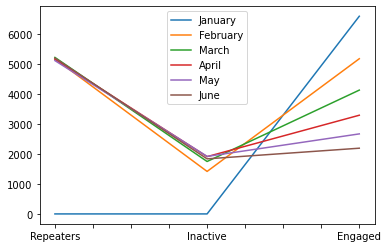

In [2]:
# A truth table to see which months a customer transacted. (from https://stackoverflow.com/questions/50765199/i-need-to-make-a-truth-table-from-pandas-dataframe-based-on-values-on-a-column) 
i, r = pd.factorize(df.name)
j, c = pd.factorize(df.transaction_date.dt.month)
b = np.zeros((r.size, c.size), int)
b[i, j] = 1

customer_df = pd.DataFrame(b, r, c)
customer = pd.DataFrame() 
months = []

# This adds the truth table values per month to see the transactions of each customer.
for i in set(df.transaction_date.dt.month):
    months.append(i)
    total = customer_df[months].sum(axis=1)
    customer[i] = total

# ENGAGED CUSTOMERS
# This checks whether the customer buys every month. (shown when the number of times the customer transacts is also the numerical equivalent of the month)
engaged_list = []
for i in set(df.transaction_date.dt.month):
    engaged_list.append(len(customer.loc[customer[i] == i]))

# INACTIVE CUSTOMERS
# This checks whether the customer bought in the previous month but not in the current month, by checking whether the current month is the same value as the previous month.
inactive_list = [0]
for i in set(df.transaction_date.dt.month):
    try:
        inactive_list.append(len(customer.loc[(customer[i+1] == customer[i]) & (customer[i] > 0)]))
    #when it reaches an error which is when it reaches the 6th month, the for loop breaks
    except KeyError:
        break

# REPEATING CUSTOMERS
# This checks whether in the first truth table, the customer bought from the previous month, regardless of whether or not they bought before.
repeaters_list = [0]
for i in set(df.transaction_date.dt.month):
    try:
        repeaters_list.append(len(customer_df.loc[(customer_df[i]+customer_df[i+1] == 2)]))
    except KeyError:
        break

# This appends the lists into a bigger list to be put into a dataframe.
customer_metrics = []
customer_metrics.append(repeaters_list)
customer_metrics.append(inactive_list)
customer_metrics.append(engaged_list)

customer_activity = pd.DataFrame(customer_metrics, columns = ['January', 'February', 'March', 'April', 'May', 'June'], index =['Repeaters','Inactive','Engaged'])
display(customer_activity)

'''Line Graph for How Customer Activity Changes Each Month'''
customer_activity.plot.line()
plt.show()